Using TensorFlow backend.


(4858, 34)
(2082, 34)
(4858, 2000)
(2082, 2000)
____________________
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 100)    10995700    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2000, 100)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1997, 10)     4010        dropout_1[0][0]                  
_______________________

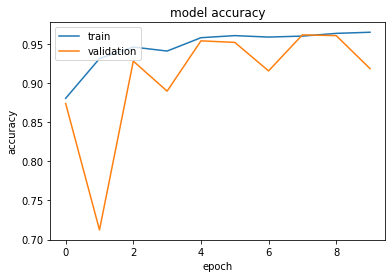

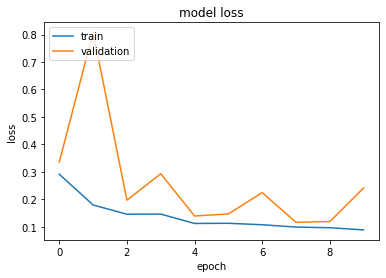

In [1]:
%tensorflow_version 2.x

#importing libraries-----------------------

from keras.utils.vis_utils import plot_model
from keras.models import Model
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.layers import Flatten, BatchNormalization, Concatenate, add
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, Conv2D
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers.merge import concatenate
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# import complete-----------------------------------------


MAX_LEN = 2000 
VOCAB_SIZE = 0
IMAGE_DIR = ''

def text_implict_preprocessing(texts):
    # initialize tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.word_index) + 1

    sequences = tokenizer.texts_to_sequences(texts)

    padded_texts = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

    return tokenizer, padded_texts, vocab_size

def load_embedding_matrix(tokenizer, VOCAB_SIZE):
    embeddings_index = dict()
    f = open('drive/My Drive/glove_data/glove.6B/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    # create a weight matrix for words in training docs
    embedding_matrix = zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def image_implicit_preprocessing(uuid, type):
    image_dataset = []
    for i in range(len(uuid)):
        sub_dir = ''
        if(type[i] == 1):
            sub_dir = 'real'
        else :
            sub_dir = 'fake'
        path = os.path.join(IMAGE_DIR, sub_dir)
        temp_img = image.load_img(os.path.join(path, str(uuid[i])+'.jpg'),target_size=(224,224))
        temp_img = image.img_to_array(temp_img)
        image_dataset.append(temp_img)

    image_dataset = np.array(image_dataset)
    image_dataset = preprocess_input(image_dataset)

    return image_dataset


# Load input dataframe
input_df = pd.read_csv('drive/My Drive/The_Research/all_data_refined_v5.csv', encoding='utf-8')

# Filter all the Dataframe where images exist
input_df = input_df[input_df['no_of_faces'] >= 0]

# converting dataframe to numpy array
input_data = input_df.to_numpy()

# extract dataset and label
X = np.delete(input_data, 6, 1)
Y = input_data[:, 6]

# Encoding the label
encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

# Split the dataset
X_train, X_valid, Y_train, Y_valid=train_test_split(X, Y, test_size=0.3, random_state=15)

print(X_train.shape)
print(X_valid.shape)

# Split dataset into branches

# Text explicit branch
X_train_text_explicit = np.concatenate((X_train[:,7:15], X_train[:,16:24], X_train[:,29:33]),axis=1)
X_valid_text_explicit = np.concatenate((X_valid[:,7:15], X_valid[:,16:24], X_valid[:,29:33]),axis=1)

# Image explicit branch
X_train_img_explicit = X_train[:,26:29]
X_valid_img_explicit = X_valid[:,26:29]

# Text implicit branch
tokenizer, padded_texts, VOCAB_SIZE = text_implict_preprocessing(np.concatenate((X_train[:,4],X_valid[:,4])))
X_train_text_implicit = padded_texts[0:X_train.shape[0]]
X_valid_text_implicit = padded_texts[X_train.shape[0]:]

print(X_train_text_implicit.shape)
print(X_valid_text_implicit.shape)

# #Load Embedding Matrix
embedding_matrix = load_embedding_matrix(tokenizer, VOCAB_SIZE)

# Image implict branch
#X_train_img_implicit = image_implicit_preprocessing(X_train[:,6], Y_train)
#X_valid_img_implicit = image_implicit_preprocessing(X_valid[:,6], Y_valid)




# splitting into test train complete -------------------------------------------------------------------

# IMPLEMENTATION OF THE MAIN MODEL START ----------------------------------------------------------

# define TEXT Implicit
inputs1 = Input(shape=(MAX_LEN,))
e = Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False)(inputs1)
a = (Dropout(0.5))(e)
b = (Conv1D(filters=10, kernel_size=(4)))(a)
c=MaxPooling1D(pool_size=2)(b)
d=Flatten()(c)
f=Dense(128)(d)
g=(BatchNormalization())(f)
z = Activation('relu')
h=(Dropout(0.8))(g)

# define TEXT Explicit
inputs2 = Input(shape=(20,))
q=(Dense(128))(inputs2)
r=(BatchNormalization())(q)
u=Activation('relu')(r)

# define IMAGE explicit

inputs3 = Input(shape=(3,))
imex2 = (Dense(128))(inputs3)
imex3 = (BatchNormalization())(imex2)
imex4 = Activation('relu')(imex3)


merged = concatenate([h, u, imex4])
dense1 = Dense(32, activation='relu')(merged)
dense2 = Dense(10, activation='relu')(dense1)
outputs = Dense(1, activation='sigmoid')(dense1)
model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



# IMPLEMENTATION OF THE MAIN MODEL COMPLETE ------------------------------------------------------------------------

# summarize the model
print("____________________")
print(model.summary())
print("____________________")

plot_model(model, show_shapes=True, to_file='multichannelbeta.png')

# fit the model
print("Fitting")
history = model.fit([X_train_text_implicit, X_train_text_explicit, X_train_img_explicit], array(Y_train), epochs=10, verbose=1, batch_size=16, validation_data = ([X_valid_text_implicit, X_valid_text_explicit, X_valid_img_explicit] , array(Y_valid)))
print("Fitted")


model_json = model.to_json()
with open("textModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("textModel.h5")
print("Saved model to disk")


# evaluate the model
print("____________________")
loss, accuracy = model.evaluate([X_valid_text_implicit, X_valid_text_explicit, X_valid_img_explicit] , array(Y_valid), verbose=1, batch_size=16)
print('Accuracy: %f' % (accuracy*100))

print("____________________")
output = model.predict([X_valid_text_implicit, X_valid_text_explicit, X_valid_img_explicit])
print(output)


def finalOutputWithDelta(delta = 0.0):
  for i in range(len(output)):
    if output[i] >= (0.5 + delta):
      output[i] = 1
    elif output[i] < (0.5 + delta):
      output[i] = 0
  error = 0
  correct = 0
  for i in range(len(output)):
    error = error + ((output[i] - Y_valid[i]) ** 2)
    if output[i] == Y_valid[i]: correct+=1

  print("error: ", error)
  print(output)
  print(correct/2291)

finalOutputWithDelta()


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [9]:

# Loading the model:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load json and create model
def loadModelAndPredict():

  #load json
  json_file = open('textModel.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  print("Loaded json from disk")

  # load weights into new model
  loaded_model.load_weights("textModel.h5")
  print("Loaded model from disk")

  loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics= ['accuracy', 'mse'])

  score = loaded_model.evaluate([X_valid_text_implicit, X_valid_text_explicit, X_valid_img_explicit] , array(Y_valid), verbose=1)

  

  return (loaded_model.metrics_names, score)

metric_name, metric_score = loadModelAndPredict()



print("%s: %.2f%%" % (metric_name[1], metric_score[1]*100))


Loaded json from disk
Loaded model from disk
2082/2082 [==============================] - 2s 1ms/step
accuracy: 91.88%
